In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import pyqg
from pyqg import diagnostic_tools as tools

In [2]:
bnn = { "beta": 1.5e-11, #[m^-1 s^-1]
       "delta": 0.25,
       "rek": 5.78e-7, #[s^-1]
       "rd": 15e3, # [m]
}

case1 = { "beta": bnn["beta"]*2/3,
            "delta": bnn["delta"]*2/5,
            "rek": bnn["rek"]*3/25,
            "rd": bnn["rd"],
}

case2 = { "beta": bnn["beta"]*3/10,
            "delta": bnn["delta"]*1/5,
            "rek": bnn["rek"]*3/50,
            "rd": bnn["rd"],
}

case3 = { "beta": bnn["beta"],
            "delta": bnn["delta"],
            "rek": bnn["rek"],
            "rd": bnn["rd"]*4/3,
}

In [3]:
year = 24*60*60*360.

print(5* year)

155520000.0


In [14]:
import torch

def EOFanalysis(X):
    E, D = torch.linalg.eig(X @ X.T)
    D = torch.abs(D)  # get magnitude of eigenvalues
    D_sum = torch.sum(D)

    for threshold, label in zip([0.85, 0.9, 0.95, 0.99], ['85%', '90%', '95%', '99%']):
        for n in range(1, 51):
            if torch.sum(D[-n:]) / D_sum >= threshold:
                print(f"{label}: {n}")
                break
    return E, D

X = torch.randn(100, 100)  # replace with your data
E, D = EOFanalysis(X)



In [ ]:
year = 24*60*60*360.
bnn_model = pyqg.QGModel(tmax=10*year, twrite=10000, tavestart=5*year, **bnn)
case1_model = pyqg.QGModel(tmax=10*year, twrite=10000, tavestart=5*year, **case1)
case2_model = pyqg.QGModel(tmax=10*year, twrite=10000, tavestart=5*year, **case2)
case3_model = pyqg.QGModel(tmax=10*year, twrite=10000, tavestart=5*year, **case3)

bnn_model.run()
case1_model.run()
case2_model.run()
case3_model.run()


In [54]:
bnn_ds = bnn_model.to_dataset().isel(time=-1)
case1_ds = case1_model.to_dataset().isel(time=-1)
case2_ds = case2_model.to_dataset().isel(time=-1)
case3_ds = case3_model.to_dataset().isel(time=-1)

bnn_ds

<xarray.Dataset>
Dimensions:            (lev: 2, y: 64, x: 64, l: 64, k: 33, lev_mid: 1)
Coordinates:
    time               float64 3.11e+08
  * lev                (lev) int64 1 2
  * lev_mid            (lev_mid) float64 1.5
  * x                  (x) float64 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
  * y                  (y) float64 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
  * l                  (l) float64 0.0 6.283e-06 ... -1.257e-05 -6.283e-06
  * k                  (k) float64 0.0 6.283e-06 ... 0.0001948 0.0002011
Data variables: (12/32)
    q                  (lev, y, x) float64 1.065e-05 7.228e-06 ... -8.173e-07
    u                  (lev, y, x) float64 -0.04502 -0.02614 ... 0.009224
    v                  (lev, y, x) float64 0.02454 0.02432 ... 0.002178 0.003838
    ufull              (lev, y, x) float64 -0.02002 -0.001141 ... 0.009224
    vfull              (lev, y, x) float64 0.02454 0.02432 ... 0.002178 0.003838
    qh                 (lev, l, k) complex128 (0.002373973976690421+0j) ... (...
    ...                 ...
    ENSgenspec         (l, k) float64 0.0 -2.183e-23 ... -3.397e-51 -6.5e-61
    ENSfrictionspec    (l, k) float64 0.0 -2.593e-24 ... -2.474e-50 -9.049e-60
    APEgenspec         (l, k) float64 0.0 -4.912e-15 ... -7.644e-43 -1.462e-52
    APEflux            (l, k) float64 -0.0 7.505e-15 ... 1.262e-28 2.853e-33
    KEflux             (l, k) float64 0.0 2.758e-15 ... 5.383e-27 1.129e-31
    APEgen             float64 6.735e-11
Attributes: (12/23)
    pyqg:beta:       1.5e-11
    pyqg:delta:      0.25
    pyqg:del2:       0.8
    pyqg:dt:         7200.0
    pyqg:filterfac:  23.6
    pyqg:L:          1000000.0
    ...              ...
    pyqg:tc:         43200
    pyqg:tmax:       311040000.0
    pyqg:twrite:     10000
    pyqg:W:          1000000.0
    title:           pyqg: Python Quasigeostrophic Model
    reference:       https://pyqg.readthedocs.io/en/latest/index.html

## This is here to be used later:

In [20]:

bnn_model.describe_diagnostics()


NAME               | DESCRIPTION
--------------------------------------------------------------------------------
APEflux    | spectral flux of available potential energy           
APEgen     | total available potential energy generation           
APEgenspec | the spectrum of the rate of generation of available potential energy
Dissspec   | Spectral contribution of filter dissipation to total energy
EKE        | mean eddy kinetic energy                              
EKEdiss    | total energy dissipation by bottom drag               
ENSDissspec | Spectral contribution of filter dissipation to barotropic enstrophy
ENSflux    | barotropic enstrophy flux                             
ENSfrictionspec | the spectrum of the rate of dissipation of barotropic enstrophy due to bottom friction
ENSgenspec | the spectrum of the rate of generation of barotropic enstrophy
Ensspec    | enstrophy spectrum                                    
KEflux     | spectral flux of kinetic energy                

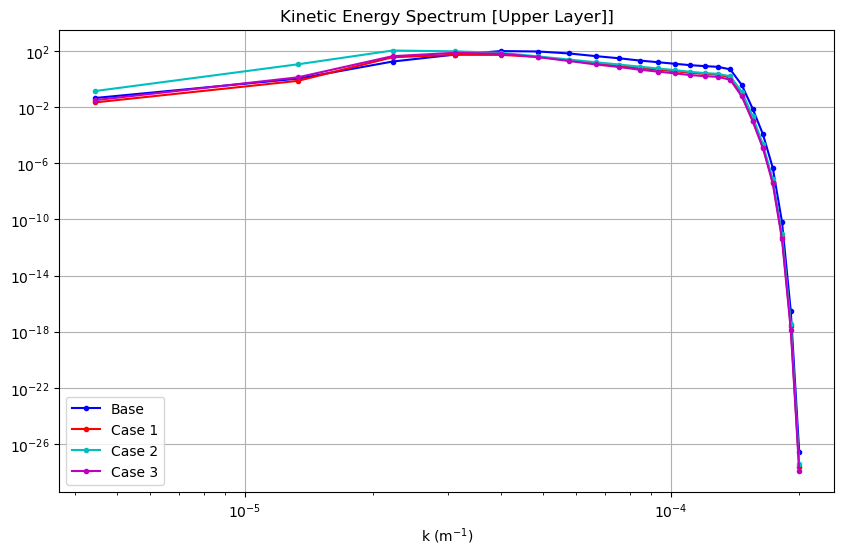

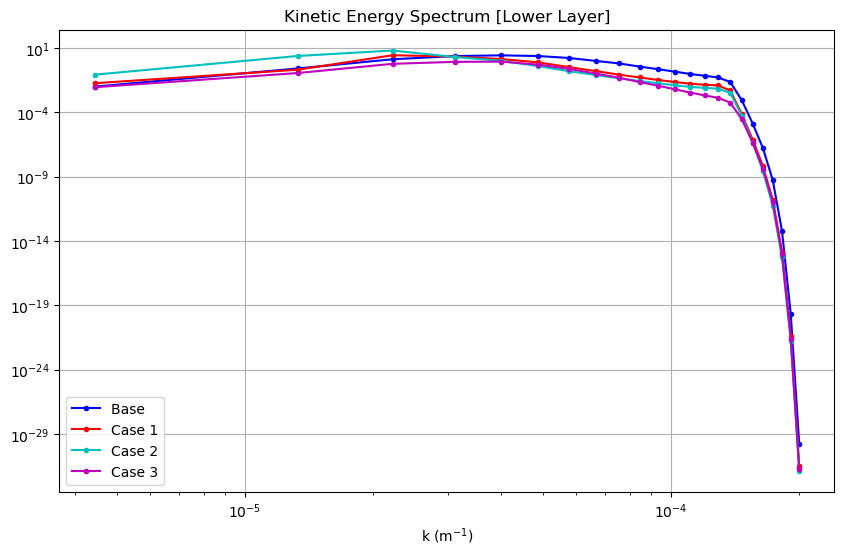

In [36]:
kr, kespec_upper_bnn = tools.calc_ispec(bnn_model, bnn_ds.KEspec.isel(lev=0).data)
_, kespec_lower_bnn = tools.calc_ispec(bnn_model, bnn_ds.KEspec.isel(lev=1).data)

_, kespec_upper_case1 = tools.calc_ispec(case1_model, case1_ds.KEspec.isel(lev=0).data)
_, kespec_lower_case1 = tools.calc_ispec(case1_model, case1_ds.KEspec.isel(lev=1).data)

_, kespec_upper_case2 = tools.calc_ispec(case2_model, case2_ds.KEspec.isel(lev=0).data)
_, kespec_lower_case2 = tools.calc_ispec(case2_model, case2_ds.KEspec.isel(lev=1).data)

_, kespec_upper_case3 = tools.calc_ispec(case3_model, case3_ds.KEspec.isel(lev=0).data)
_, kespec_lower_case3 = tools.calc_ispec(case3_model, case3_ds.KEspec.isel(lev=1).data)

# Creating subplots
plt.figure(figsize=(10,6))
plt.loglog(kr, kespec_upper_bnn, 'b.-', label='Base')
plt.loglog(kr, kespec_upper_case1, 'r.-', label='Case 1')
plt.loglog(kr, kespec_upper_case2, 'c.-', label='Case 2')
plt.loglog(kr, kespec_upper_case3, 'm.-', label='Case 3')
plt.legend(loc='lower left')
plt.xlabel(r'k (m$^{-1}$)'); plt.grid()
plt.title('Kinetic Energy Spectrum [Upper Layer]]')

plt.figure(figsize=(10,6))
plt.loglog(kr, kespec_lower_bnn, 'b.-', label='Base ')
plt.loglog(kr, kespec_lower_case1, 'r.-', label='Case 1')
plt.loglog(kr, kespec_lower_case2, 'c.-', label='Case 2')
plt.loglog(kr, kespec_lower_case3, 'm.-', label='Case 3')
plt.title('Kinetic Energy Spectrum [Lower Layer]')
plt.legend(loc='lower left')
plt.xlabel(r'k (m$^{-1}$)'); plt.grid()


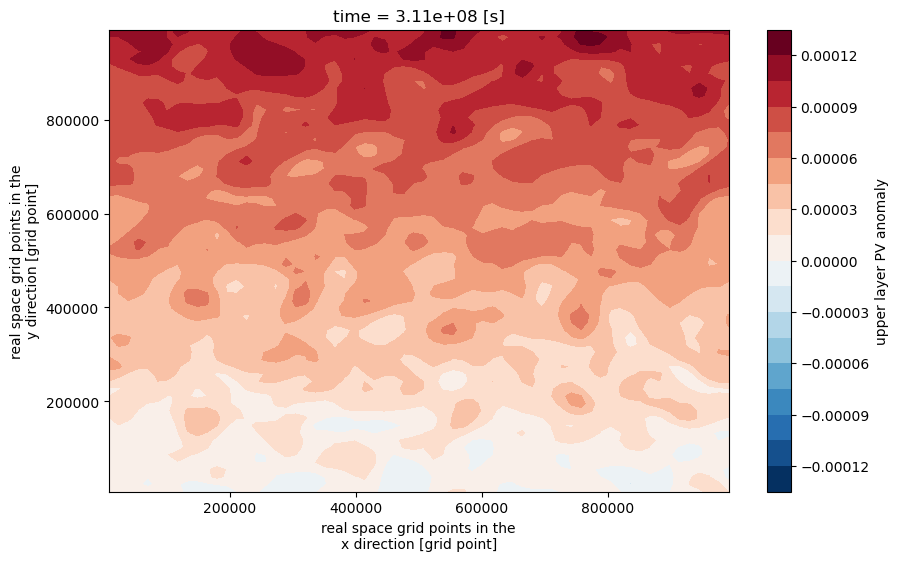

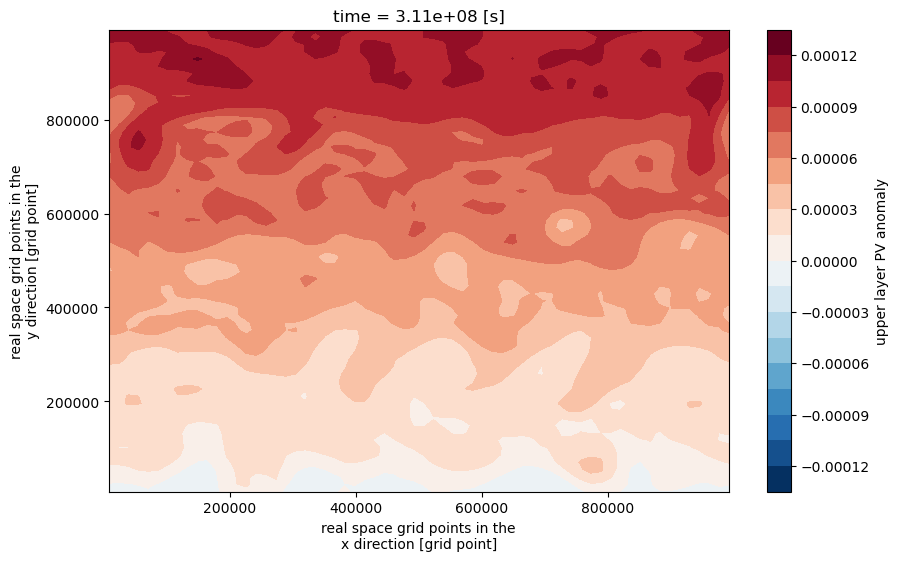

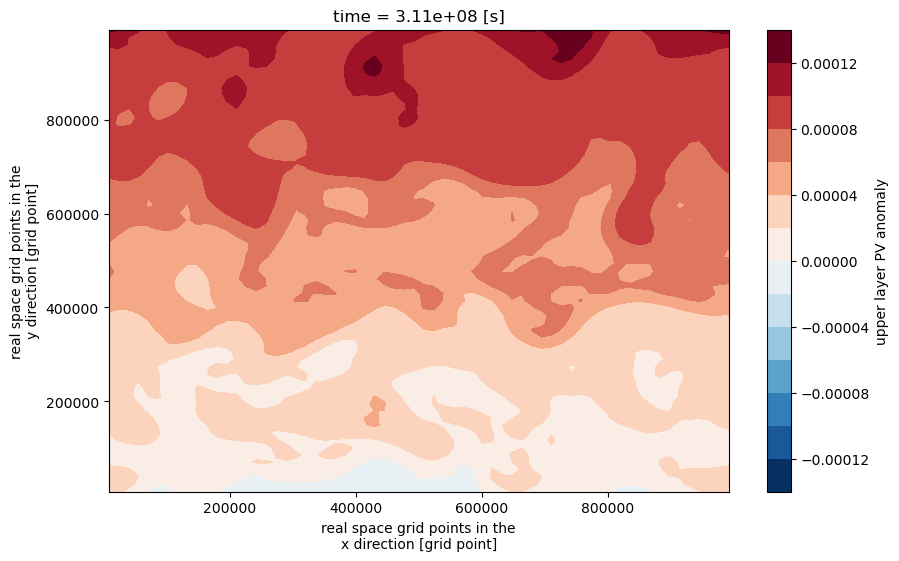

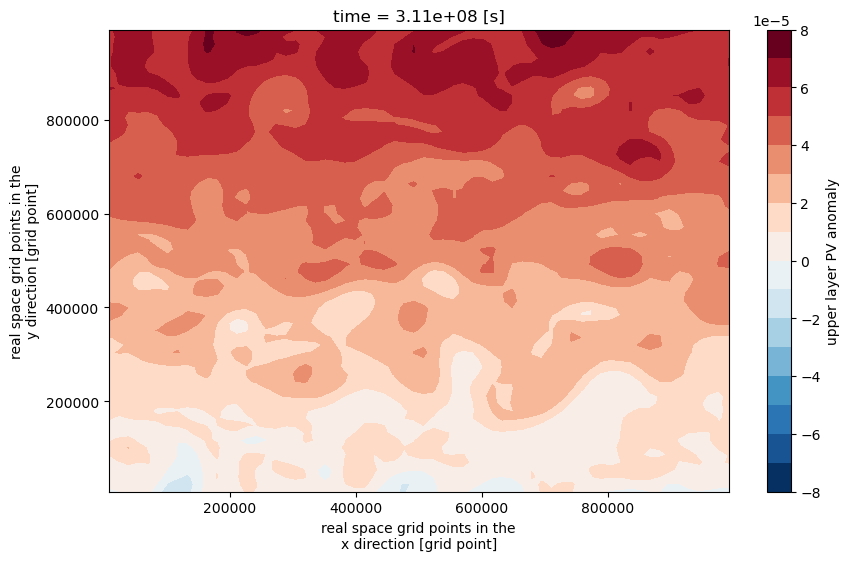

In [45]:
plt.figure(figsize=(10,6))
bnn_ds['q_upper'] = bnn_ds.q.isel(lev=0) + bnn_ds.Qy.isel(lev=0)*bnn_ds.y
bnn_ds['q_upper'].attrs = {'long_name': 'upper layer PV anomaly'}
bnn_ds.q_upper.plot.contourf(levels=18, cmap='RdBu_r');

plt.figure(figsize=(10,6))
case1_ds['q_upper'] = case1_ds.q.isel(lev=0) + case1_ds.Qy.isel(lev=0)*case1_ds.y
case1_ds['q_upper'].attrs = {'long_name': 'upper layer PV anomaly'}
case1_ds.q_upper.plot.contourf(levels=18, cmap='RdBu_r');

plt.figure(figsize=(10,6))
case2_ds['q_upper'] = case2_ds.q.isel(lev=0) + case2_ds.Qy.isel(lev=0)*case2_ds.y
case2_ds['q_upper'].attrs = {'long_name': 'upper layer PV anomaly'}
case2_ds.q_upper.plot.contourf(levels=18, cmap='RdBu_r');

plt.figure(figsize=(10,6))
case3_ds['q_upper'] = case3_ds.q.isel(lev=0) + case3_ds.Qy.isel(lev=0)*case3_ds.y
case3_ds['q_upper'].attrs = {'long_name': 'upper layer PV anomaly'}
case3_ds.q_upper.plot.contourf(levels=18, cmap='RdBu_r');


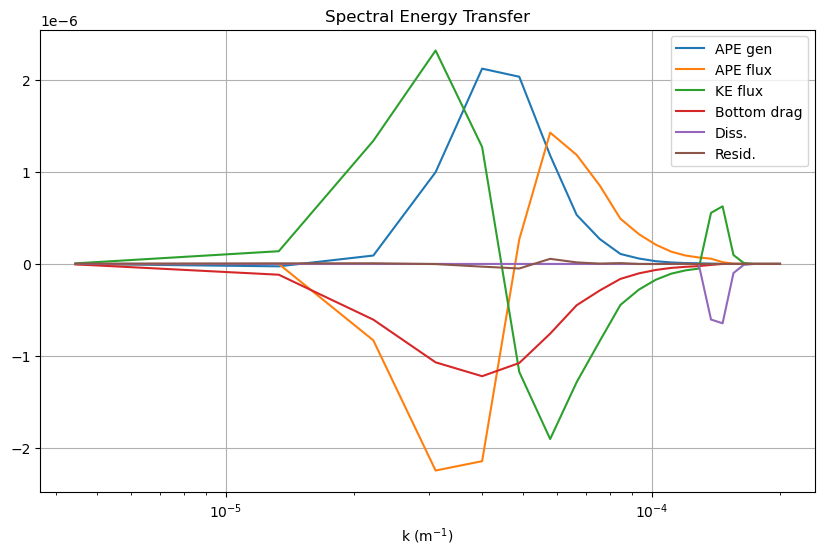

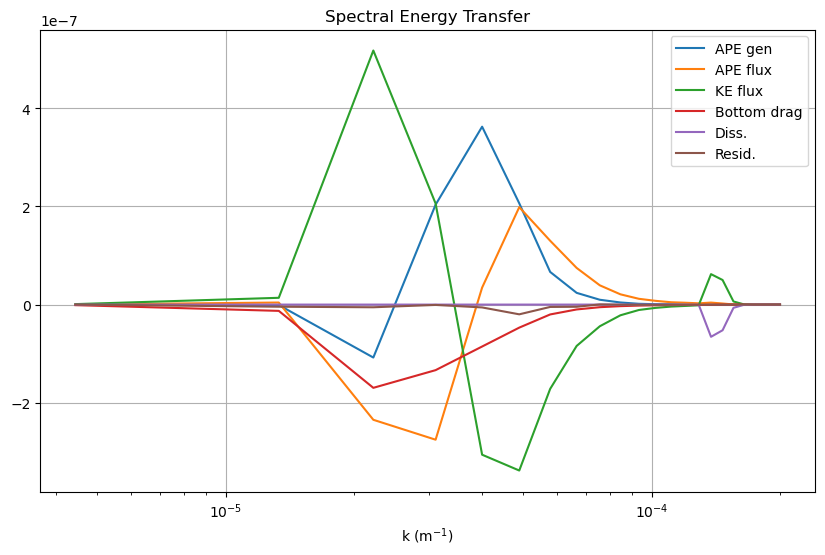

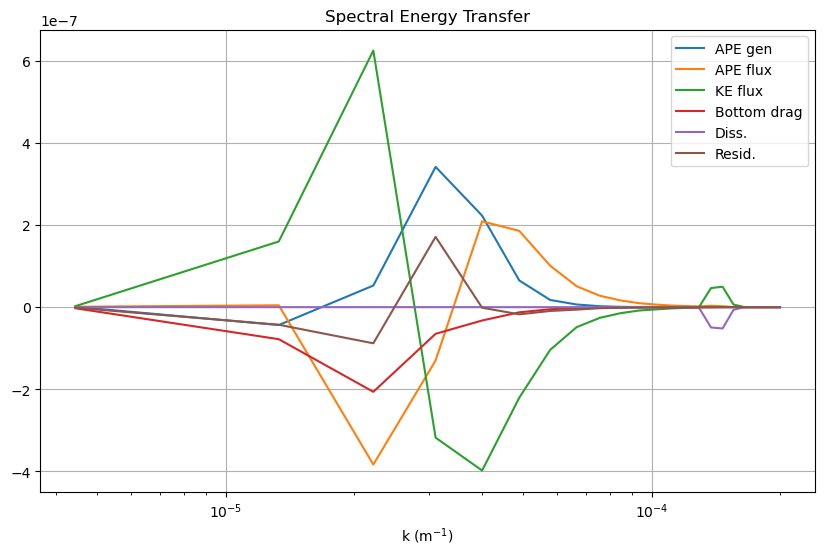

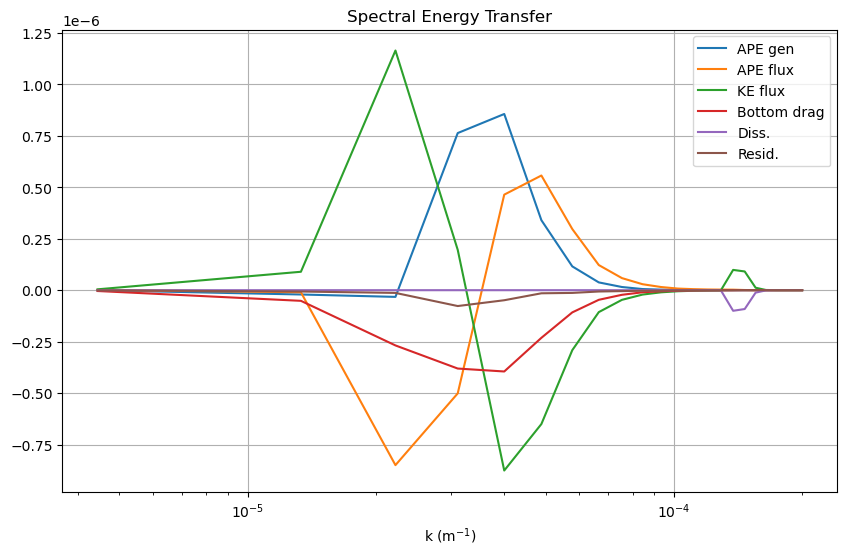

In [42]:
for m, m_ds in zip([bnn_model, case1_model, case2_model, case3_model], [bnn_ds, case1_ds, case2_ds, case3_ds]):
    kr, APEgenspec = tools.calc_ispec(m, m_ds.APEgenspec.data)
    _, APEflux     = tools.calc_ispec(m, m_ds.APEflux.data)
    _, KEflux      = tools.calc_ispec(m, m_ds.KEflux.data)
    _, KEfrictionspec = tools.calc_ispec(m, m_ds.KEfrictionspec.data)
    _, Dissspec    = tools.calc_ispec(m, m_ds.Dissspec.data)

    ebud = [ APEgenspec,
            APEflux,
            KEflux,
            KEfrictionspec,
            Dissspec]
    ebud.append(-np.vstack(ebud).sum(axis=0))
    ebud_labels = ['APE gen','APE flux','KE flux','Bottom drag','Diss.','Resid.']
    plt.figure(figsize=(10,6))
    [plt.semilogx(kr, term) for term in ebud]
    plt.legend(ebud_labels, loc='upper right')
    plt.xlabel(r'k (m$^{-1}$)'); plt.grid()
    plt.title('Spectral Energy Transfer');

In [57]:
# Chcek data shape and play with xarray
bnn_ds 
# Save xarray dataset to netcdf



<xarray.Dataset>
Dimensions:            (lev: 2, y: 64, x: 64, l: 64, k: 33, lev_mid: 1)
Coordinates:
    time               float64 3.11e+08
  * lev                (lev) int64 1 2
  * lev_mid            (lev_mid) float64 1.5
  * x                  (x) float64 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
  * y                  (y) float64 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
  * l                  (l) float64 0.0 6.283e-06 ... -1.257e-05 -6.283e-06
  * k                  (k) float64 0.0 6.283e-06 ... 0.0001948 0.0002011
Data variables: (12/32)
    q                  (lev, y, x) float64 1.065e-05 7.228e-06 ... -8.173e-07
    u                  (lev, y, x) float64 -0.04502 -0.02614 ... 0.009224
    v                  (lev, y, x) float64 0.02454 0.02432 ... 0.002178 0.003838
    ufull              (lev, y, x) float64 -0.02002 -0.001141 ... 0.009224
    vfull              (lev, y, x) float64 0.02454 0.02432 ... 0.002178 0.003838
    qh                 (lev, l, k) complex128 (0.002373973976690421+0j) ... (...
    ...                 ...
    ENSgenspec         (l, k) float64 0.0 -2.183e-23 ... -3.397e-51 -6.5e-61
    ENSfrictionspec    (l, k) float64 0.0 -2.593e-24 ... -2.474e-50 -9.049e-60
    APEgenspec         (l, k) float64 0.0 -4.912e-15 ... -7.644e-43 -1.462e-52
    APEflux            (l, k) float64 -0.0 7.505e-15 ... 1.262e-28 2.853e-33
    KEflux             (l, k) float64 0.0 2.758e-15 ... 5.383e-27 1.129e-31
    APEgen             float64 6.735e-11
Attributes: (12/23)
    pyqg:beta:       1.5e-11
    pyqg:delta:      0.25
    pyqg:del2:       0.8
    pyqg:dt:         7200.0
    pyqg:filterfac:  23.6
    pyqg:L:          1000000.0
    ...              ...
    pyqg:tc:         43200
    pyqg:tmax:       311040000.0
    pyqg:twrite:     10000
    pyqg:W:          1000000.0
    title:           pyqg: Python Quasigeostrophic Model
    reference:       https://pyqg.readthedocs.io/en/latest/index.html